<a href="https://colab.research.google.com/github/erd96/trading-pattern-recognition/blob/main/CandlestickPatternDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


# Dataset Generation Functions


In [2]:
import csv
import pathlib
import os
import pandas as pd
import numpy as np
import random as rd
from datetime import timedelta
import mplfinance as mpf


# Check if the directory exists, otherwise create it
directory = 'patterns_dataset'
if not os.path.exists(directory):
    os.makedirs(directory)



classes = ["Rising Wedge", "Falling Wedge", "Symmetrical Triangle", "Ascending Triangle", "Descending Triangle" ,"No Patterns" ]



def write_to_csv(image):
    csv_file_path = str(image["path"].parent) + "/patterns_dataset.csv"
    label = [1 if image["class"] == c else 0 for c in classes]
    if not os.path.isfile(csv_file_path):
        with open(csv_file_path, mode='w', newline='') as label_file:
            label_writer = csv.writer(label_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            label_writer.writerow(['filename', classes[0], classes[1], classes[2], classes[3],
                                   classes[4], classes[5]])

    filename = image["path"].name
    with open(csv_file_path, mode='a', newline='') as label_file:
        label_writer = csv.writer(label_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        label_writer.writerow([filename, label[0], label[1], label[2], label[3],
                               label[4], label[5]])



def create_image(open_data, high_data, low_data, close_data,path):
    base = pd.to_datetime('2023-01-01')
    dates = [base + timedelta(days=i) for i in range(len(open_data))]

    df = pd.DataFrame({'Date': dates, 'Open': open_data, 'High': high_data, 'Low': low_data, 'Close': close_data})
    df.set_index('Date', inplace=True)
    custom_style = mpf.make_mpf_style(base_mpf_style='charles', gridstyle='')
    figsize_multiplier = 0.5
    fig = mpf.plot(df, type='candle', style=custom_style, title='', ylabel='Price', axisoff=True,  figsize=(len(open_data) * figsize_multiplier*0.3, 6*0.3), savefig=path, scale_padding=0)


def check_high_low(close_price, open_price, high_price, low_price):
    if close_price > open_price :
              high_price = high_price if high_price > close_price else close_price
              low_price = low_price if low_price < open_price else open_price
    if close_price < open_price :
        high_price = high_price if high_price > open_price else open_price
        low_price = low_price if low_price < close_price else close_price

    return high_price, low_price


def generate_rising_wedge(index=0):
    num_data_points = rd.randint(6, 30)
    lower_slope = np.random.uniform(0.1, 2)
    upper_slope = np.random.uniform(0.1, lower_slope - 0.2)  # Ensuring upper slope is less than lower slope
    bias = np.random.uniform(0.1, 0.5)

    x = np.linspace(0, num_data_points, num_data_points) # Generate x values
    lower_line = lower_slope * x
    upper_line = upper_slope * (x - num_data_points) + lower_line[-1] + bias

    open_data, close_data, high_data, low_data  = [], [], [], []
    split =  num_data_points//3
    start, mid, end = x[0:split], x[split :split*2], x[split*2:]
    ltouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()
    utouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()


    current_price = (upper_line[0] + lower_line[0]) / 2
    for i in range(num_data_points):
        open_price = current_price

        if i in ltouches:
          close_or_low = rd.choice([True, False])
          if close_or_low:
            close_price =  lower_line[i]
            low_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            low_price =  lower_line[i]
          high_price =  np.random.uniform(lower_line[i], upper_line[i])

        elif i in utouches:
          close_or_high = rd.choice([True, False])
          if close_or_high:
            close_price =  upper_line[i]
            high_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            high_price =  upper_line[i]
          low_price =  np.random.uniform(lower_line[i], upper_line[i])
        else:
          close_price =  np.random.uniform(lower_line[i], upper_line[i])
          high_price =  np.random.uniform(lower_line[i], upper_line[i])
          low_price =  np.random.uniform(lower_line[i], upper_line[i])

        high_price, low_price = check_high_low(close_price, open_price, high_price, low_price)

        open_data.append(open_price)
        close_data.append(close_price)
        high_data.append(high_price)
        low_data.append(low_price)

        current_price = close_price  # Set the current price for the next iteration

    path = pathlib.Path(directory) / f"r_wedge{index}.jpg"
    create_image(open_data, high_data, low_data, close_data, path)

    return {"path":path, "class":"Rising Wedge"}


def generate_falling_wedge(index=0):
    num_data_points = rd.randint(6, 30)
    upper_slope = -np.random.uniform(0.1, 2)
    lower_slope = np.random.uniform(-0.1, upper_slope +0.2)  # Ensuring upper slope is less than lower slope
    bias = -np.random.uniform(0.1, 0.5)

    x = np.linspace(0, num_data_points, num_data_points) # Generate x values
    upper_line = upper_slope * x
    lower_line = lower_slope * (x - num_data_points) + upper_line[-1] + bias
    open_data, close_data, high_data, low_data  = [], [], [], []

    split =  num_data_points//3
    start, mid, end = x[0:split], x[split :split*2], x[split*2:]
    ltouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()
    utouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()

    current_price = (upper_line[0] + lower_line[0]) / 2
    for i in range(num_data_points):
        open_price = current_price

        if i in ltouches:
          close_or_low = rd.choice([True, False])
          if close_or_low:
            close_price =  lower_line[i]
            low_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            low_price =  lower_line[i]
          high_price =  np.random.uniform(lower_line[i], upper_line[i])

        elif i in utouches:
          close_or_high = rd.choice([True, False])
          if close_or_high:
            close_price =  upper_line[i]
            high_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            high_price =  upper_line[i]
          low_price =  np.random.uniform(lower_line[i], upper_line[i])
        else:
          close_price =  np.random.uniform(lower_line[i], upper_line[i])
          high_price =  np.random.uniform(lower_line[i], upper_line[i])
          low_price =  np.random.uniform(lower_line[i], upper_line[i])

        high_price, low_price = check_high_low(close_price, open_price, high_price, low_price)

        open_data.append(open_price)
        close_data.append(close_price)
        high_data.append(high_price)
        low_data.append(low_price)

        current_price = close_price  # Set the current price for the next iteration


    path = pathlib.Path(directory) / f"f_wedge{index}.jpg"
    create_image(open_data, high_data, low_data, close_data, path)

    return {"path":path, "class":"Falling Wedge"}




def generate_symmetrical_triangle(index=0):
    num_data_points = rd.randint(6, 30)
    upper_slope = -np.random.uniform(0.1, 2)
    lower_slope = -upper_slope  # Ensuring upper slope is less than lower slope
    bias = -np.random.uniform(0.1, 0.5)

    x = np.linspace(0, num_data_points, num_data_points) # Generate x values

    upper_line = upper_slope * x
    lower_line = lower_slope * (x - num_data_points) + upper_line[-1] + bias
    open_data, close_data, high_data, low_data  = [], [], [], []

    split =  num_data_points//3
    start, mid, end = x[0:split], x[split :split*2], x[split*2:]
    ltouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()
    utouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()

    current_price = (upper_line[0] + lower_line[0]) / 2
    for i in range(num_data_points):
        open_price = current_price

        if i in ltouches:
          close_or_low = rd.choice([True, False])
          if close_or_low:
            close_price =  lower_line[i]
            low_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            low_price =  lower_line[i]
          high_price =  np.random.uniform(lower_line[i], upper_line[i])

        elif i in utouches:
          close_or_high = rd.choice([True, False])
          if close_or_high:
            close_price =  upper_line[i]
            high_price =  np.random.uniform(lower_line[i], upper_line[i])
          else:
            close_price =  np.random.uniform(lower_line[i], upper_line[i])
            high_price =  upper_line[i]
          low_price =  np.random.uniform(lower_line[i], upper_line[i])
        else:
          close_price =  np.random.uniform(lower_line[i], upper_line[i])
          high_price =  np.random.uniform(lower_line[i], upper_line[i])
          low_price =  np.random.uniform(lower_line[i], upper_line[i])

        high_price, low_price = check_high_low(close_price, open_price, high_price, low_price)

        open_data.append(open_price)
        close_data.append(close_price)
        high_data.append(high_price)
        low_data.append(low_price)

        current_price = close_price  # Set the current price for the next iteration


    path = pathlib.Path(directory) / f"sym_tri{index}.jpg"
    create_image(open_data, high_data, low_data, close_data, path)

    return {"path":path, "class":"Symmetrical Triangle"}


def generate_ascending_triangle(index=0):
  num_data_points = rd.randint(6, 30)
  x = np.linspace(0, num_data_points, num_data_points)
  support_slope = np.random.uniform(0.1, 2)
  support_line = support_slope * x
  resistance_line = np.ones_like(x) * np.max(support_line)

  open_data, close_data, high_data, low_data  = [], [], [], []

  split = num_data_points // 3
  start, mid, end = x[0:split], x[split :split*2], x[split*2:]
  ltouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()
  utouches = np.concatenate([np.where(x == rd.choice(start))[0], np.where(x == rd.choice(mid))[0], np.where(x == rd.choice(end))[0]]).tolist()


  current_price = (support_line[0] + resistance_line[0]) / 2

  for i in range(num_data_points):
      open_price = current_price

      if i in ltouches:
        close_or_low = rd.choice([True, False])
        if close_or_low:
          close_price =  support_line[i]
          low_price =  np.random.uniform(support_line[i], resistance_line[i])
        else:
          close_price =  np.random.uniform(support_line[i], resistance_line[i])
          low_price =  support_line[i]
        high_price =  np.random.uniform(support_line[i], resistance_line[i])

      elif i in utouches:
        close_or_high = rd.choice([True, False])
        if close_or_high:
          close_price =  resistance_line[i]
          high_price =  np.random.uniform(support_line[i], resistance_line[i])
        else:
          close_price =  np.random.uniform(support_line[i], resistance_line[i])
          high_price =  resistance_line[i]
        low_price =  np.random.uniform(support_line[i], resistance_line[i])
      else:
        close_price =  np.random.uniform(support_line[i], resistance_line[i])
        high_price =  np.random.uniform(support_line[i], resistance_line[i])
        low_price =  np.random.uniform(support_line[i], resistance_line[i])

      high_price, low_price = check_high_low(close_price, open_price, high_price, low_price)

      open_data.append(open_price)
      close_data.append(close_price)
      high_data.append(high_price)
      low_data.append(low_price)

      current_price = close_price  # Set the current price for the next iteration

  path = pathlib.Path(directory) / f"asc_triangle{index}.jpg"
  create_image(open_data, high_data, low_data, close_data, path)

  return {"path":path, "class":"Ascending Triangle"}


def generate_descending_triangle(index=0):
  num_data_points = rd.randint(6, 30)
  x = np.linspace(0, num_data_points, num_data_points)   # Generate x values

  resistance_slope = -np.random.uniform(0.1, 2)
  resistance_line = resistance_slope * x
  support_line = np.ones_like(x) * np.min(resistance_line)

  open_data, close_data, high_data, low_data  = [], [], [], []

  split = num_data_points // 3
  start, mid, end = x[0:split], x[split:split*2], x[split*2:]
  ltouches = np.concatenate([np.where(x == np.random.choice(start))[0], np.where(x == np.random.choice(mid))[0], np.where(x == np.random.choice(end))[0]]).tolist()
  utouches = np.concatenate([np.where(x == np.random.choice(start))[0], np.where(x == np.random.choice(mid))[0], np.where(x == np.random.choice(end))[0]]).tolist()

  current_price = (support_line[0] + resistance_line[0]) / 2

  for i in range(num_data_points):
      open_price = current_price

      if i in ltouches:
          close_or_low = np.random.choice([True, False])
          if close_or_low:
              close_price = support_line[i]
              low_price = np.random.uniform(support_line[i], resistance_line[i])
              high_price = support_line[i]
          else:
              close_price = np.random.uniform(support_line[i], resistance_line[i])
              low_price = support_line[i]
              high_price = np.random.uniform(support_line[i], resistance_line[i])
      elif i in utouches:
          close_or_high = np.random.choice([True, False])
          if close_or_high:
              close_price = resistance_line[i]
              low_price = np.random.uniform(support_line[i], resistance_line[i])
              high_price = np.random.uniform(support_line[i], resistance_line[i])
          else:
              close_price = np.random.uniform(support_line[i], resistance_line[i])
              low_price = np.random.uniform(support_line[i], resistance_line[i])
              high_price = resistance_line[i]
      else:
          close_price = np.random.uniform(support_line[i], resistance_line[i])
          low_price = np.random.uniform(support_line[i], resistance_line[i])
          high_price = np.random.uniform(support_line[i], resistance_line[i])

      high_price, low_price = check_high_low(close_price, open_price, high_price, low_price)

      open_data.append(open_price)
      close_data.append(close_price)
      high_data.append(high_price)
      low_data.append(low_price)

      current_price = close_price  # Set the current price for the next iteration

  path = pathlib.Path(directory) / f"desc_triangle{index}.jpg"
  create_image(open_data, high_data, low_data, close_data, path)

  return {"path":path, "class":"Descending Triangle"}


def generate_no_pattern(index=0):
    choice = rd.choice([True, False])
    if choice: num_data_points = rd.randint(1, 6)
    else: num_data_points = rd.randint(6, 30)

    # Generate random prices for the candlestick data
    open_data = np.random.randint(100, 500, num_data_points)
    close_data = np.random.randint(100, 500, num_data_points)
    high_data = np.random.randint(100, 500, num_data_points)
    low_data = np.random.randint(100, 500, num_data_points)

    for i, (open_price, high_price, low_price, close_price) in enumerate(zip(open_data, high_data, low_data, close_data)):
        if close_price > open_price:
            high_data[i] = max(high_price, close_price)
            low_data[i] = min(low_price, open_price)
        elif close_price < open_price:
            high_data[i] = max(high_price, open_price)
            low_data[i] = min(low_price, close_price)

    path = pathlib.Path(directory) / f"no_pattern_{index}.jpg"
    create_image(open_data, high_data, low_data, close_data, path)
    return {"path": path, "class": "No Patterns"}

**Creating the dataset**

In [3]:
for i in range(500):
    write_to_csv(generate_rising_wedge(i))
    write_to_csv(generate_falling_wedge(i))
    write_to_csv(generate_symmetrical_triangle(i))
    write_to_csv(generate_ascending_triangle(i))
    write_to_csv(generate_descending_triangle(i))
    write_to_csv(generate_no_pattern(i))


# Loading the Dataset

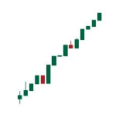

In [4]:
import pandas as pd
import numpy as np
import cv2
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from sklearn.utils import shuffle


# Step 1: Load the data
data = pd.read_csv('patterns_dataset/patterns_dataset.csv')

# Step 2: Preprocess the data
images = []
labels = []

for index, row in data.iterrows():
    img = cv2.imread('patterns_dataset/' + row['filename'])
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    images.append(img.astype('float32') / 255)  # Convert to float32 and normalize
    labels.append(row[["Rising Wedge", "Falling Wedge", "Symmetrical Triangle", "Ascending Triangle", "Descending Triangle" ,"No Patterns" ]].values.astype('float32'))

images = np.array(images)
labels = np.array(labels)

# Display the image in its true size without scaling
fig, ax = plt.subplots(figsize=(images[0].shape[1] / plt.rcParams['figure.dpi'], images[0].shape[0] / plt.rcParams['figure.dpi']))
ax.imshow(images[0])
ax.axis('off')
plt.show()

**Dataset Segmentation & Augmentation**

In [5]:
def augment_data(images, labels):
    datagen = ImageDataGenerator(zoom_range=[2, 3])
    augmented_images = []
    augmented_labels = []

    for i in range(images.shape[0]):
        img = images[i]
        label = labels[i]

        augmented_images.append(img)
        augmented_labels.append(label)

        # Generate 2 zoom variants
        for j in range(2):
            augmented_img = datagen.random_transform(img)
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)



# Shuffle the data
images_shuffled, labels_shuffled = shuffle(images, labels, random_state=42)

# Split the data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.3, random_state=42)
X_train, y_train = augment_data(X_train, y_train)
X_val_test, y_val_test = augment_data(X_val_test, y_val_test)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


# Building the Model

In [6]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Add dropout before the final dense layer

model.add(Dense(6, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

# Training the Model

In [7]:
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001 * np.exp(-epoch / 10)
    else:
        return 0.0001 * np.exp(-(epoch-10) / 10)

lr_schedule = LearningRateScheduler(lr_scheduler)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[lr_schedule])

model.save('patterns_classification_model.h5')


Epoch 1/10
197/197 [==============================] - 51s 252ms/step - loss: 0.5015 - accuracy: 0.8167 - val_loss: 0.2122 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 2/10
197/197 [==============================] - 48s 244ms/step - loss: 0.2254 - accuracy: 0.9268 - val_loss: 0.1922 - val_accuracy: 0.9333 - lr: 9.0484e-04
Epoch 3/10
197/197 [==============================] - 49s 249ms/step - loss: 0.1727 - accuracy: 0.9457 - val_loss: 0.1839 - val_accuracy: 0.9422 - lr: 8.1873e-04
Epoch 4/10
197/197 [==============================] - 49s 248ms/step - loss: 0.1474 - accuracy: 0.9468 - val_loss: 0.1549 - val_accuracy: 0.9519 - lr: 7.4082e-04
Epoch 5/10
197/197 [==============================] - 63s 319ms/step - loss: 0.1057 - accuracy: 0.9652 - val_loss: 0.1356 - val_accuracy: 0.9578 - lr: 6.7032e-04
Epoch 6/10
197/197 [==============================] - 49s 249ms/step - loss: 0.0924 - accuracy: 0.9694 - val_loss: 0.1416 - val_accuracy: 0.9570 - lr: 6.0653e-04
Epoch 7/10
197/197 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Plot training & validation accuracy values**

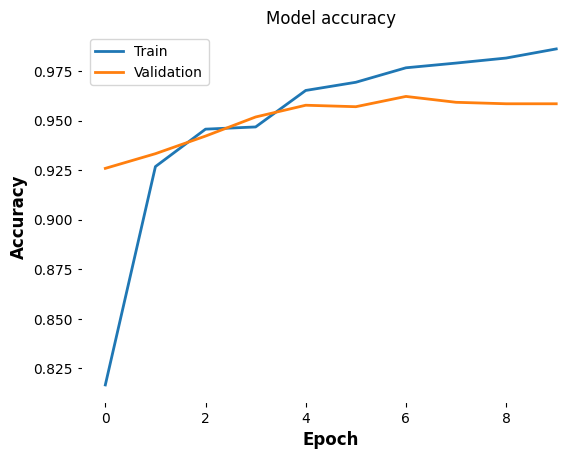

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing the Model

**10 Random Predictions**

1/1 [==============================] - 0s 18ms/step


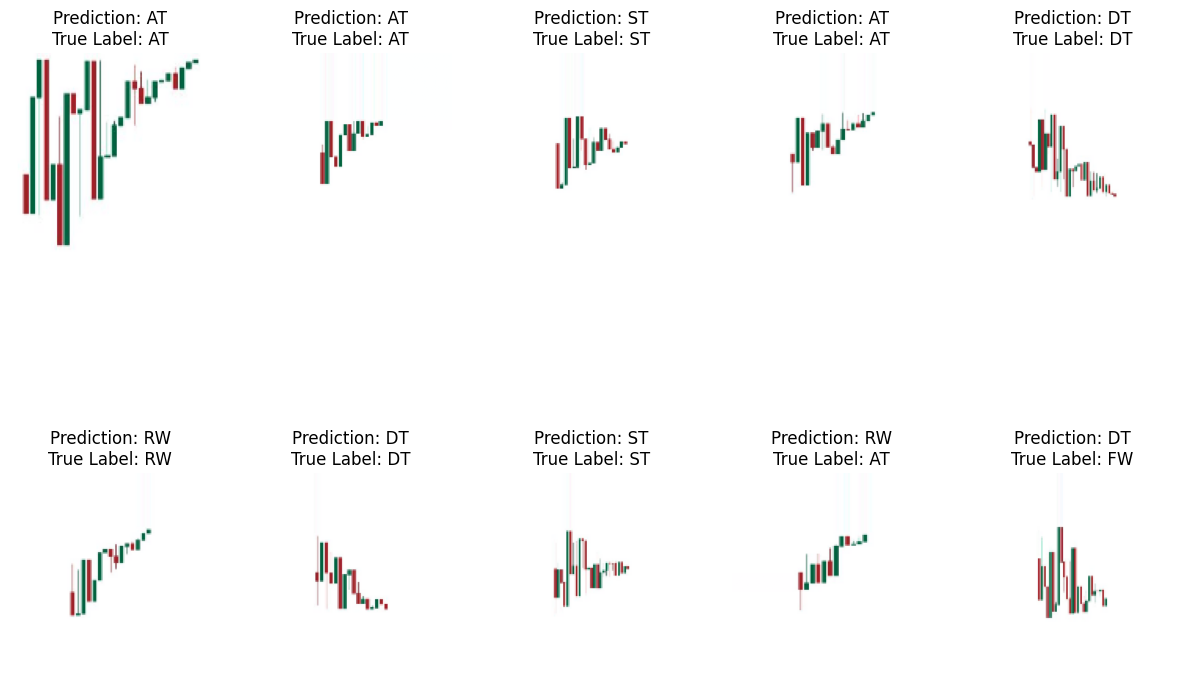

In [9]:
pattern_classes = ["RW", "FW", "ST", "AT", "DT" ,"NP" ]

num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 10))
for i, sample_index in enumerate(random_indices):
    sample_image = X_test[sample_index]
    sample_label = y_test[sample_index]
    sample_image = sample_image.reshape(1, 128, 128, 3)
    prediction = model.predict(sample_image)

    # Convert the prediction and ground truth label to readable format
    prediction_label = pattern_classes[np.argmax(prediction)]
    true_label = pattern_classes[np.argmax(sample_label)]

    # Display the sample image and its corresponding prediction
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_image[0])
    plt.title(f'Prediction: {prediction_label}\nTrue Label: {true_label}')
    plt.axis('off')

plt.show()

**Confusion Matrix**

43/43 [==============================] - 4s 92ms/step


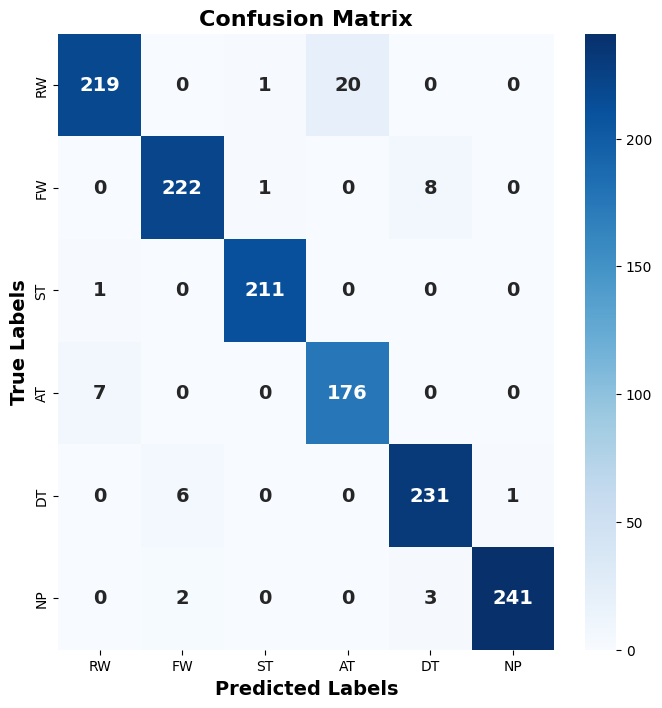

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pattern_classes, yticklabels=pattern_classes,
            annot_kws={'size': 14, 'weight': 'bold'})

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.show()

**Confusion Matrix Metrics**

In [11]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1] + conf_matrix[2, 2] + conf_matrix[3, 3] + conf_matrix[4, 4] + conf_matrix[5, 5]) / np.sum(conf_matrix)
precision = conf_matrix.diagonal() / np.sum(conf_matrix, axis=0)
recall = conf_matrix.diagonal() / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1_score}')

Accuracy: 0.9630
Precision: [0.96475771 0.96521739 0.99061033 0.89795918 0.95454545 0.99586777]
Recall: [0.9125     0.96103896 0.99528302 0.96174863 0.97058824 0.9796748 ]
F1-Score: [0.9379015  0.96312364 0.99294118 0.92875989 0.9625     0.98770492]


# Using the Saved Model

In [44]:
import requests
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import date2num

def generate_bitcoin_chart(num_data_points=0):
    num_data_points = num_data_points if num_data_points else rd.randint(6, 20)

    url = f"https://api.binance.us/api/v3/klines"
    params = {
        "symbol": "BTCUSDT",
        "interval": "1h",
        "limit": num_data_points
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raises an exception if the request is unsuccessful
        response = response.json()
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    # Candlestick data within the boundary lines
    dates = [pd.to_datetime(entry[0], unit='ms') for entry in response]
    open_data = [float(entry[1]) for entry in response]
    high_data = [float(entry[2]) for entry in response]
    low_data = [float(entry[3]) for entry in response]
    close_data = [float(entry[4]) for entry in response]
    volume = [float(entry[5]) for entry in response]


    df= pd.DataFrame({'date':dates, 'open':open_data, "high":high_data, "low":low_data, "close":close_data})

    # Convert date to numerical format
    df['numdate'] = date2num(df['date'])

    x_min, x_max = df['numdate'].min(), df['numdate'].max()
    width = (x_max - x_min) / num_data_points

    fig, ax = plt.subplots()
    candlestick_ohlc(ax, zip(df['numdate'], df['open'], df['high'], df['low'], df['close']),
                 width=width, colorup='#006340', colordown='#a02128')

    ax.axis('off')
    ax.set_aspect('auto')
    ax.set_ylim(df['low'].min(), df['high'].max())
    axes = plt.gca()

    plt.tight_layout()
    # Get the x-pixel coordinates of the left and right sides of the first candlestick
    x_data = df['numdate'].iloc[0]  # Use the first data point for simplicity
    x_pixel_left = ax.transData.transform((x_data - width / 2, 0))[0]
    x_pixel_right = ax.transData.transform((x_data + width / 2, 0))[0]

    # Calculate the candlestick width in pixels
    candlestick_width_pixels = x_pixel_right - x_pixel_left

    save_path = "bitcoin_chart.jpg"
    fig.savefig(save_path, format='jpg')
    plt.close(fig)
    return save_path, df, candlestick_width_pixels

chart_path, df, cwidth = generate_bitcoin_chart(200)


**Load and display the saved chart**

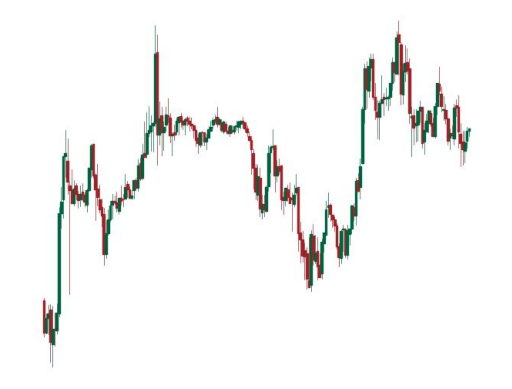

In [45]:
def rgb_and_normalize(img_path):
    img_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)  # Swap BGR to RGB
    img_cv2 = img_cv2.astype('float32') / 255
    return img_cv2

img_array = rgb_and_normalize(chart_path)
plt.imshow(img_array)
plt.axis('off')
plt.show()

**Show the Resulting Bounding Boxes**

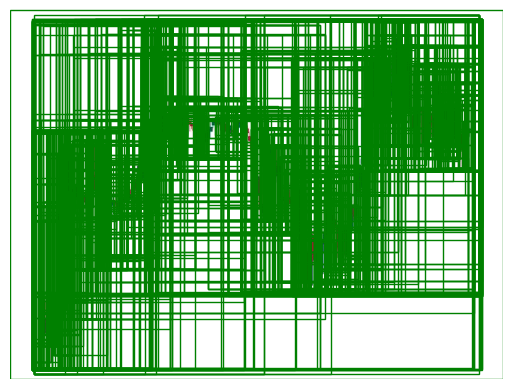

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def selectiveSearchFast(img): # OpenCV's Selective search fast algorithm. Returns arrays of type [x1,y1, w, h].
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchQuality()
    bounding_boxes = ss.process()
    return bounding_boxes

bboxes = selectiveSearchFast(img_array)
bboxes = [bbox for bbox in bboxes if bbox[2] >= 6 * cwidth]

def show_image_with_boxes(image, bounding_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bounding_boxes:
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

show_image_with_boxes(img_array, bboxes)

**Create the Bounding Box Images**

In [47]:
def create_bounding_box_images(image, bounding_boxes):
    bounding_box_images = []

    for i, bbox in enumerate(bounding_boxes):
        x, y, w, h = bbox
        top = y
        bottom = y + h - 1

        # Check if the top or bottom rows are already white, reduce dimensions if necessary
        while top < bottom and np.all(image[top, x:x + w] == 1):
            top += 1

        while top < bottom and np.all(image[bottom, x:x + w] == 1):
            bottom -= 1

        # Check top row
        while top > 0 and not np.all(image[top-1, x:x + w] == 1):
            top -= 1

        # Check bottom row
        while bottom < image.shape[0] - 1 and not np.all(image[bottom+1, x:x + w] == 1):
            bottom += 1

        # Update the bounding box
        new_y = top
        new_h = bottom - top + 1  # Adjust height based on top and bottom

        bbox_image = image[new_y:new_y + new_h, x:x + w]
        bounding_box_images.append(((x, new_y, w, new_h), bbox_image))

    return bounding_box_images

bounding_box_images_array = create_bounding_box_images(img_array, bboxes)

**Forward Propogation of Each Bounding Box Image**

In [48]:
from tensorflow.keras.models import load_model

model_path = 'patterns_classification_model.h5'
model = load_model(model_path)

results = []
resized_width, resized_height = 128,128

for i, image in enumerate(bounding_box_images_array):
    bbox, img = image
    resized_image = cv2.resize(img, (resized_width, resized_height), cv2.INTER_LINEAR)
    reshaped_image = np.reshape(resized_image, (1, resized_width, resized_height, 3))  # Add batch dimension
    raw_prediction = model.predict(reshaped_image)
    prediction_label = "NP" if np.max(raw_prediction) < 0.99 else pattern_classes[np.argmax(raw_prediction)]
    results.append((bbox, raw_prediction, prediction_label))

print("BBoxes # Original: ", len(results))
results = [(bbox, raw_prediction, prediction) for bbox, raw_prediction, prediction in results if prediction != "NP"]
print("BBoxes # Filtered: ", len(results))


1/1 [==============================] - 0s 20ms/step
BBoxes # Original:  2017
BBoxes # Filtered:  137


**Non-Max Suppression**

In [49]:
def non_max_suppression(boxes):
    if len(boxes) == 0:
        return []

    # Sort the boxes based on the maximum confidence scores
    boxes = sorted(boxes, key=lambda x: np.max(x[1]), reverse=True)

    # Initialize a list to store the selected bounding boxes after NMS
    selected_boxes = [boxes[0]]

    # Loop over the remaining boxes
    for box in boxes[1:]:
        # Check if the current box overlaps with any of the selected boxes with the same prediction
        overlap = False
        for selected_box in selected_boxes:
            if box[2] == selected_box[2]:  # Check if predictions are the same
                x1 = max(box[0][0], selected_box[0][0])
                y1 = max(box[0][1], selected_box[0][1])
                x2 = min(box[0][0] + box[0][2], selected_box[0][0] + selected_box[0][2])
                y2 = min(box[0][1] + box[0][3], selected_box[0][1] + selected_box[0][3])

                intersection = max(0, x2 - x1) * max(0, y2 - y1)
                area_box = box[0][2] * box[0][3]
                area_selected = selected_box[0][2] * selected_box[0][3]
                union = area_box + area_selected - intersection

                # Calculate the IoU
                iou = intersection / union

                # If the boxes overlap, set the flag to True
                if iou > 0:
                    overlap = True
                    break

        # If the box doesn't overlap with any selected box with the same prediction, add it
        if not overlap:
            selected_boxes.append(box)

    return selected_boxes

filtered_results = non_max_suppression(results)

print("BBoxes # After NMS: ", len(filtered_results))

BBoxes # After NMS:  7


# Displaying Final Results

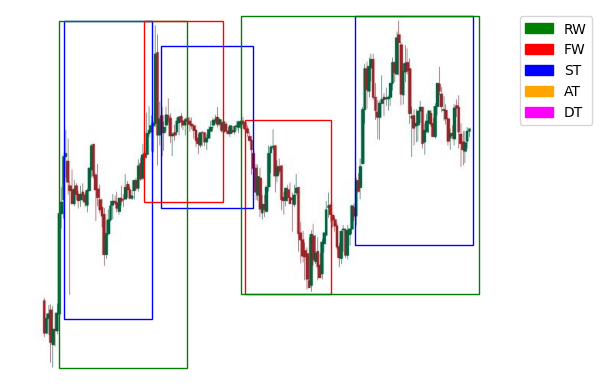

In [56]:
import cv2
from google.colab.patches import cv2_imshow


class_colors = {
    "RW":  "green",
    "FW": "red",
    "ST": "blue",
    "AT":  "orange",
    "DT": "magenta",
}


imOut = img_array.copy()

def show_image_with_boxes(image, bounding_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    legend_patches = []

    for label, color in class_colors.items():
        rect = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor=color, facecolor=color)
        legend_patches.append(rect)

    plt.legend(legend_patches, class_colors.keys(), loc='upper left', bbox_to_anchor=(1.02, 1))

    for bbox in bounding_boxes:
        x, y, w, h = bbox[0]
        prediction_label = bbox[2]
        color = class_colors.get(prediction_label)
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

show_image_with_boxes(imOut, filtered_results)